<a href="https://colab.research.google.com/github/ayouba83/projet_ias/blob/main/data_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import gc
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import os
from huggingface_hub import login
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## Load dataset

In [21]:
data = pd.read_csv("/content/train.csv")
data.head()

,text,titles
0,Thierry Mariani sur la liste du Rassemblement ...,L'information n'a pas été confirmée par l'inté...
1,C'est désormais officiel : Alain Juppé n'est p...,Le maire de Bordeaux ne fait plus partie des R...
2,La mesure est décriée par les avocats et les m...,"En 2020, les tribunaux d'instance fusionnent a..."
3,Dans une interview accordée au Figaro mercredi...,"Les médecins jugés ""gros prescripteurs d'arrêt..."
4,Le préjudice est estimé à 2 millions d'euros. ...,Il aura fallu mobiliser 90 gendarmes pour cett...


In [22]:
data = data.drop("titles", axis=1).iloc[:5000]
data

,text
0,Thierry Mariani sur la liste du Rassemblement ...
1,C'est désormais officiel : Alain Juppé n'est p...
2,La mesure est décriée par les avocats et les m...
3,Dans une interview accordée au Figaro mercredi...
4,Le préjudice est estimé à 2 millions d'euros. ...
...,...
4995,"""Ces robots sont si petits qu'ils sont invisib..."
4996,"L'Histoire décidera s'ils sont devenus la ""Gén..."
4997,"Dans l'Etat de Puebla, ""au moins 96 personnes ..."
4998,"Le gouvernement d'Édouard Philippe a pris de ""..."


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
dtypes: object(1)
memory usage: 39.2+ KB


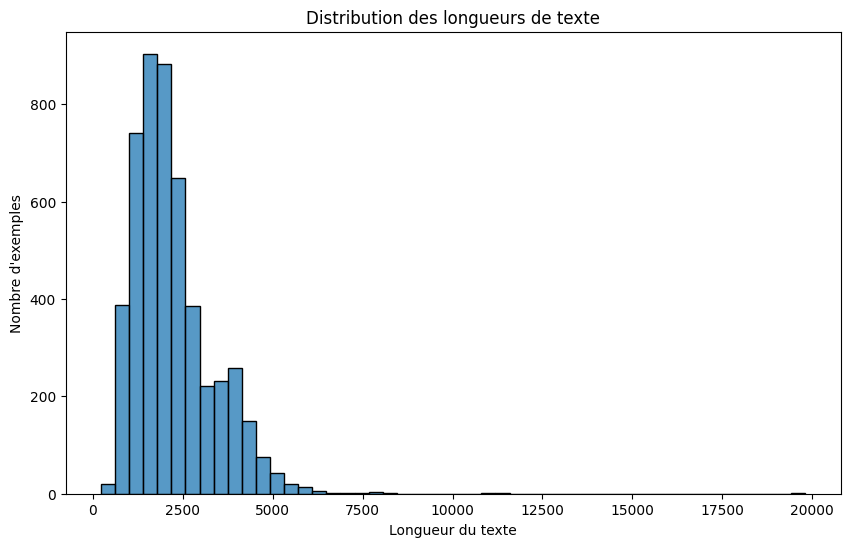

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

text_lengths = data['text'].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=50, kde=False)
plt.xlabel("Longueur du texte")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution des longueurs de texte")
plt.show()


In [25]:
def get_first_longest_text_example(df, text_col='text'):
    """
    Retourne le premier exemple (une seule ligne) du DataFrame dont le texte (dans la colonne `text_col`)
    est le plus long.
    """
    text_lengths = df[text_col].str.len()
    max_index = text_lengths.idxmax()
    return df.loc[[max_index]]

In [26]:
texts = get_first_longest_text_example(data)
len(texts.iloc[0, 0])

19810

## Load the model

In the next cell, we'll load the Mistral-7B-Instruct-v0.2 model. This is a powerful 7B parameter instruction-tuned language model that can be used for various text generation tasks, including the summarization task we're working on.

We're applying 4-bit quantization through BitsAndBytes to reduce memory requirements while maintaining good performance. This configuration:
- Loads the model in 4-bit precision
- Uses float16 for compute operations
- Applies double quantization for further memory optimization
- Uses "nf4" (normalized float 4) quantization type
- Automatically places model weights on the available GPU using device_map="auto"

This approach allows us to work with this large language model in a constrainted environment.


In [11]:
!pip install -U bitsandbytes

In [12]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quantization_config
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Testing Summarization on a Sample Document

This summarize_text function generates concise summaries from French texts using a the model. It wraps each input text in a prompt that instructs the model to create a summary with specific formatting requirements.

We tokenize these prompts and sends them to the model's device for processing. Then,  the model produces summary texts that follows the given instructions.



In [13]:
import torch

model.eval()

def generate_batch_summaries(texts, max_length=300, num_beams=4):
    # Format Mistral-7B-Instruct correct avec [INST]
    prompts = [
        f"[INST] Résumez en Français le texte ci-dessous en un paragraphe de 3 à 5 phrases maximum, de manière concise :\n\n{text}\n[/INST]"
        for text in texts
    ]

    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(model.device)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                num_beams=num_beams,
                early_stopping=True,
                eos_token_id=tokenizer.eos_token_id,  # Arrêter à la fin de séquence
                do_sample=False
            )

    # Extraction de seulement la partie générée (après le prompt)
    #input_lengths = inputs.input_ids.shape[1]
    #generated_tokens = outputs[:, input_lengths:]
    summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return summaries

def extract_generated_text(text):
    """
    Si le texte contient [/INST], retourne ce qui vient après.
    Sinon, retourne la partie après le dernier saut de ligne.
    """
    if "[/INST]" in text:
        # On découpe sur [/INST] et on récupère la partie après.
        return text.split("[/INST]", 1)[1].strip()
    else:
        # Si un saut de ligne existe, on récupère la partie après le dernier \n
        if "\n" in text:
            return text.rsplit("\n", 1)[1].strip()
        else:
            # Sinon, on renvoie le texte entier, épuré des espaces en trop.
            return text.strip()

def generate_batch_summaries(texts, max_length=500, num_beams=4):
    # Format Mistral-7B-Instruct avec les balises [INST] ... [/INST]
    prompts = [
        f"[INST] Résumez en Français le texte ci-dessous en un paragraphe de 3 à 5 phrases maximum, de manière concise. Terminez toujours par un point. :\n\n{text} [/INST]"
        for text in texts
    ]

    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(model.device)

    with torch.no_grad():
        with torch.cuda.amp.autocast():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                num_beams=num_beams,
                early_stopping=True,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False
            )
            torch.cuda.empty_cache()  # Force le nettoyage de la mémoire GPU
            gc.collect()

    # Décodage des tokens générés
    raw_summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    # Extraction du résumé proprement dit selon la présence du tag [/INST] ou du dernier \n
    summaries = [extract_generated_text(summary) for summary in raw_summaries]
      # Nettoyage explicite


    return summaries


BATCH_SIZE = 40  # testez plus grand pour exploiter les 40 Go GPU
gc.collect()
torch.cuda.empty_cache()
texts = data["text"].tolist()
summaries = []

for i in tqdm(range(0, len(texts), BATCH_SIZE)):
    gc.collect()
    torch.cuda.empty_cache()  # Libère le cache GPU
    batch_texts = texts[i:i+BATCH_SIZE]
    batch_summaries = generate_batch_summaries(batch_texts)
    summaries.extend(batch_summaries)

data["summarize"] = summaries
data.to_csv("dataset.csv", index=False)


  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-13-6611f636a8c3>:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
100%|██████████| 25/25 [1:15:13<00:00, 180.53s/it]
